In [ ]:
import streamlit as st
import os
import json
from typing import TypedDict, Annotated, Sequence, Optional
from pydantic import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
import pathlib
from utils import clean_json, build_db_catalog, format_catalog_for_llm, execute_sql_query, web_search, omdb_api

# Load environment
load_dotenv()

# API Keys
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OMDB_API_KEY = os.getenv("OMDB_API_KEY")
OMDB_BASE_URL = "http://www.omdbapi.com/"

# Paths
PROJECT_ROOT = pathlib.Path("C:/Users/Vincent/GitHub/Vincent-20-100/Agentic_Systems_Project_Vlamy")
DB_FOLDER_PATH = str(PROJECT_ROOT / "data" / "databases")

if not OPENAI_API_KEY:
    st.error("❌ OPENAI_API_KEY missing")
    st.stop()

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, api_key=OPENAI_API_KEY)

# === STRUCTURED OUTPUTS ===

class PlannerOutput(BaseModel):
    """Planner decision output"""
    resolved_query: str = Field(..., description="Query reformulated with context from history")
    planning_reasoning: str = Field(..., description="Why these tools are needed")
    needs_sql: bool = Field(default=False, description="Whether SQL query is needed")
    needs_omdb: bool = Field(default=False, description="Whether OMDB enrichment is needed")
    needs_web: bool = Field(default=False, description="Whether web search is needed")
    sql_query: Optional[str] = Field(None, description="Prepared SQL query if needed")
    omdb_query: Optional[str] = Field(None, description="Title to search in OMDB if needed")
    web_query: Optional[str] = Field(None, description="Web search query if needed")

class SQLOutput(BaseModel):
    """SQL execution decision"""
    can_answer: bool = Field(..., description="Whether SQL can answer the query")
    db_name: Optional[str] = Field(None, description="Database to query")
    query: Optional[str] = Field(None, description="SQL query to execute")
    reasoning: str = Field(..., description="Why this query or why SQL cannot answer")

# === AGENT STATE ===

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    db_catalog: dict
    # Planning
    original_question: str
    resolved_query: str
    planning_reasoning: str
    # Tool queries
    sql_query: str
    omdb_query: str
    web_query: str
    # Tool flags
    needs_sql: bool
    needs_omdb: bool
    needs_web: bool
    # Tool results
    sql_result: str
    omdb_result: str
    web_result: str
    # Metadata
    sources_used: list
    sources_detailed: list
    current_step: str

# === WORKFLOW NODES ===

def planner_node(state: AgentState) -> dict:
    """Analyze query and decide which tools to use (can select multiple)"""
    question = state.get("original_question", "")
    history = state.get("messages", [])
    catalog = state.get("db_catalog", {})
    previous_synthesis = state.get("synthesis", "")

    # Get accumulated results
    sql_res = state.get("sql_result", "")
    omdb_res = state.get("omdb_result", "")
    web_res = state.get("web_result", "")
    catalog_info = format_catalog_for_llm(catalog)

    prompt = f"""You are a planning agent that decides which tools to use to answer the user's question.

ORIGINAL QUESTION: "{question}"

CONVERSATION HISTORY (last 5 messages):
{json.dumps([{"role": m.type, "content": m.content} for m in history[-5:]], indent=2)}

{catalog_info}

PREVIOUS SYNTHESIS:
{previous_synthesis if previous_synthesis else "❌ No synthesis yet (first pass)"}

DATA ALREADY COLLECTED:
--- SQL Results ---
{sql_res if sql_res else "❌ Not yet retrieved"}

--- OMDB Data ---
{omdb_res if omdb_res else "❌ Not yet retrieved"}

--- Web Results ---
{web_res if web_res else "❌ Not yet retrieved"}

AVAILABLE TOOLS:
1. **SQL Database** - Query structured movie/series data (titles, ratings, years, genres, cast, directors)
2. **OMDB API** - Get detailed info (posters, full plot, awards) - **REQUIRES exact movie title**
3. **Web Search** - Recent news, reviews, trending topics

YOUR JOB:
Decide which tools are needed to answer the question. You can select:
- **One tool** (e.g., only SQL)
- **Multiple tools** (e.g., SQL + OMDB + Web)
- **No tools** (if you have all data needed → all needs_* = False)

DECISION LOGIC:
1. **If this is a follow-up after synthesis**: Check what the synthesis said was missing
2. **Missing structured data** (titles, ratings, years) → needs_sql = True
3. **Have titles but missing posters/details** → needs_omdb = True (provide exact title in omdb_query)
4. **Need current news/reviews** → needs_web = True
5. **Schema/catalog questions** → NO tools needed (catalog has everything)
6. **Sufficient data** → all needs_* = False (go directly to synthesis)

EXAMPLES:
- "Get Inception's poster" → needs_sql=True (verify title), needs_omdb=True (get poster)
- "Top 5 Nolan movies" → needs_sql=True only
- "Inception poster and recent news" → needs_sql=True, needs_omdb=True, needs_web=True
- "What tables exist?" → all False (catalog has schema)

IMPORTANT:
- For OMDB: if you don't have the exact title yet, wait for SQL first
- Prepare ALL queries (sql_query, omdb_query, web_query) for selected tools
- Resolve references from history (e.g., "that movie" → actual name)

OUTPUT: Structured decision with tool flags and prepared queries"""

    structured_llm = llm.with_structured_output(PlannerOutput)

    try:
        plan = structured_llm.invoke(prompt)

        return {
            "resolved_query": plan.resolved_query,
            "planning_reasoning": plan.planning_reasoning,
            "needs_sql": plan.needs_sql,
            "needs_omdb": plan.needs_omdb,
            "needs_web": plan.needs_web,
            "sql_query": plan.sql_query or "",
            "omdb_query": plan.omdb_query or "",
            "web_query": plan.web_query or "",
            "current_step": "planned"
        }
    except Exception as e:
        return {
            "resolved_query": question,
            "planning_reasoning": f"Planning error: {str(e)}",
            "needs_sql": False,
            "needs_omdb": False,
            "needs_web": False,
            "sql_query": "",
            "omdb_query": "",
            "web_query": "",
            "current_step": "planned"
        }

def sql_node(state: AgentState) -> dict:
    """Execute SQL query"""
    catalog = state.get("db_catalog", {})
    resolved_query = state.get("resolved_query", "")
    catalog_info = format_catalog_for_llm(catalog)

    prompt = f"""Generate a precise SQL query to answer: "{resolved_query}"

{catalog_info}

CRITICAL INSTRUCTIONS:
1. **Table Names**: Use the EXACT table name from the catalog (e.g., 'shows', NOT 'movies' or 'netflix')
2. **Type Filtering**:
   - For movies: WHERE type = 'Movie'
   - For TV shows: WHERE type = 'TV Show'
   - Check the 'type' column unique values in the catalog above
3. **Genre Search**:
   - Genres are in 'listed_in' column as comma-separated strings
   - Use: WHERE listed_in LIKE '%Action%' or '%Action & Adventure%'
   - Check the 'ALL INDIVIDUAL GENRES' list in the catalog to use exact genre names
4. **Year Filtering**:
   - Column: 'release_year' (INTEGER)
   - For 2000s: WHERE release_year >= 2000 AND release_year <= 2009
   - Check the unique values range in the catalog
5. **Text Search**:
   - Title: WHERE title LIKE '%keyword%'
   - Description: WHERE description LIKE '%keyword%'
6. **Always use LIMIT**: Default 10, maximum 50
7. **ORDER BY**: Use DESC for highest first (ratings, year)

EXAMPLE QUERIES:
- "action movies from 2000s":
  SELECT * FROM shows WHERE type = 'Movie' AND listed_in LIKE '%Action%' AND release_year BETWEEN 2000 AND 2009 LIMIT 10

- "top rated comedies":
  SELECT * FROM shows WHERE type = 'Movie' AND listed_in LIKE '%Comed%' ORDER BY rating DESC LIMIT 10

OUTPUT: SQL decision with database name and query"""

    structured_llm = llm.with_structured_output(SQLOutput)
    
    try:
        decision = structured_llm.invoke(prompt)
        
        if decision.can_answer and decision.query and decision.db_name:
            result = execute_sql_query.invoke({
                "query": decision.query,
                "db_name": decision.db_name,
                "state_catalog": catalog
            })

            # Extract table name from query
            table_name = "unknown"
            if "FROM" in decision.query.upper():
                try:
                    from_clause = decision.query.upper().split("FROM")[1].split()[0]
                    table_name = from_clause.strip()
                except:
                    pass

            # Create detailed source
            detailed_source = {
                "type": "database",
                "name": decision.db_name.replace("_", " ").title(),
                "details": f"Table: {table_name}"
            }

            return {
                "sql_result": result,
                "sources_used": state.get("sources_used", []) + [f"DB: {decision.db_name}"],
                "sources_detailed": state.get("sources_detailed", []) + [detailed_source],
                "current_step": "sql_executed"
            }
        else:
            return {
                "sql_result": json.dumps({"info": decision.reasoning}),
                "current_step": "sql_skipped"
            }
    except Exception as e:
        return {
            "sql_result": json.dumps({"error": str(e)}),
            "current_step": "sql_error"
        }

def omdb_node(state: AgentState) -> dict:
    """Execute OMDB query"""
    omdb_query = state.get("omdb_query", "")
    sql_result = state.get("sql_result", "[]")
    
    # Try to get title from OMDB query or SQL result
    title = omdb_query
    
    if not title:
        try:
            data = json.loads(sql_result)
            if isinstance(data, list) and len(data) > 0:
                item = data[0]
                title = item.get("title") or item.get("Title") or item.get("name")
        except:
            pass
    
    if title:
        try:
            result = omdb_api.invoke({"by": "title", "t": title, "plot": "full"})

            # Try to extract IMDb ID for clickable link
            imdb_url = None
            try:
                result_data = json.loads(result)
                if "imdbID" in result_data:
                    imdb_id = result_data["imdbID"]
                    imdb_url = f"https://www.imdb.com/title/{imdb_id}/"
            except:
                pass

            # Create detailed source
            detailed_source = {
                "type": "omdb",
                "name": f"OMDB: {title}",
                "url": imdb_url
            }

            return {
                "omdb_result": result,
                "sources_used": state.get("sources_used", []) + [f"OMDB: {title}"],
                "sources_detailed": state.get("sources_detailed", []) + [detailed_source],
                "current_step": "omdb_executed"
            }
        except Exception as e:
            return {
                "omdb_result": json.dumps({"error": str(e)}),
                "current_step": "omdb_error"
            }
    
    return {
        "omdb_result": "{}",
        "current_step": "omdb_skipped"
    }

def web_node(state: AgentState) -> dict:
    """Execute web search"""
    web_query = state.get("web_query", "")
    
    if not web_query:
        web_query = state.get("resolved_query", "")
    
    try:
        result = web_search.invoke({"query": web_query, "num_results": 5})

        # Create DuckDuckGo search URL
        import urllib.parse
        search_url = f"https://duckduckgo.com/?q={urllib.parse.quote(web_query)}"

        # Create detailed source
        detailed_source = {
            "type": "web",
            "name": "Web Search",
            "url": search_url
        }

        return {
            "web_result": result,
            "sources_used": state.get("sources_used", []) + ["Web Search"],
            "sources_detailed": state.get("sources_detailed", []) + [detailed_source],
            "current_step": "web_executed"
        }
    except Exception as e:
        return {
            "web_result": json.dumps({"error": str(e)}),
            "current_step": "web_error"
        }

def synthesizer_node(state: AgentState) -> dict:
    """Generate final response and decide if more data is needed"""
    question = state.get("original_question", "")
    resolved = state.get("resolved_query", "")
    reasoning = state.get("planning_reasoning", "")
    sql = state.get("sql_result", "[]")
    omdb = state.get("omdb_result", "{}")
    web = state.get("web_result", "{}")
    sources = state.get("sources_used", [])
    catalog = state.get("db_catalog", {})

    catalog_info = format_catalog_for_llm(catalog)

    prompt = f"""Generate a natural, helpful response using all available data.

ORIGINAL QUESTION: "{question}"
RESOLVED QUERY: "{resolved}"
PLANNING CONTEXT: {reasoning}

DATABASE SCHEMA:
{catalog_info}

AVAILABLE DATA:
--- SQL Results ---
{sql}

--- OMDB Data ---
{omdb}

--- Web Results ---
{web}

SOURCES: {', '.join(sources)}

YOUR TASKS:
1. **Answer the question** naturally and clearly in French
2. **Evaluate completeness**: Do we have enough data to fully answer?
   - If missing critical info (e.g., asked for poster but no OMDB data) → mention it
   - If sufficient data → provide complete answer

INSTRUCTIONS:
- Integrate all source data seamlessly
- Cite sources when mentioning facts
- Keep responses concise but complete
- Use natural language, not raw JSON
- If data is incomplete, clearly state what's missing

At the end, add a special marker:
- If answer is complete: [COMPLETE]
- If need more data: [NEED_MORE_DATA: explain what's missing]"""

    response = llm.invoke(prompt)
    content = response.content

    # Check if we need more data
    needs_more_data = "[NEED_MORE_DATA" in content

    # Clean the marker from final response
    clean_content = content.split("[COMPLETE]")[0].split("[NEED_MORE_DATA")[0].strip()

    return {
        "synthesis": clean_content,
        "needs_more_data": needs_more_data,
        "messages": [AIMessage(content=clean_content)],
        "current_step": "synthesized"
    }

# === ROUTING ===

def should_run_sql(state: AgentState) -> bool:
    """Check if SQL should run"""
    return state.get("needs_sql", False)

def should_run_omdb(state: AgentState) -> bool:
    """Check if OMDB should run"""
    return state.get("needs_omdb", False)

def should_run_web(state: AgentState) -> bool:
    """Check if web search should run"""
    return state.get("needs_web", False)

def route_from_planner(state: AgentState) -> str:
    """Route from planner to first tool or synthesizer"""
    iteration = state.get("iteration_count", 0)
    if iteration > 5:
          return "synthesize"    # Prevent infinite loops (max 5 iterations)
    if state.get("needs_sql"):
        return "sql"
    elif state.get("needs_omdb"):
        return "omdb"
    elif state.get("needs_web"):
        return "web"
    else:
        return "synthesize"

def route_from_synthesizer(state: AgentState) -> str:
    """Decide if we need more data or can end"""
    needs_more = state.get("needs_more_data", False)
    
    if needs_more:
        return "planner"
    else:
        return END

# === BUILD GRAPH ===

@st.cache_resource
def build_agent():
    """Build workflow with planner loop"""
    workflow = StateGraph(AgentState)

    workflow.add_node("planner", planner_node)
    workflow.add_node("sql", sql_node)
    workflow.add_node("omdb", omdb_node)
    workflow.add_node("web", web_node)
    workflow.add_node("synthesize", synthesizer_node)

    workflow.add_edge(START, "planner")

    # Planner peut lancer un ou plusieurs tools
    workflow.add_conditional_edges("planner", route_from_planner, ["sql", "omdb", "web", "synthesize"])
    
    # Tous les tools vont vers synthesize
    workflow.add_edge("sql", "synthesize")
    workflow.add_edge("omdb", "synthesize")
    workflow.add_edge("web", "synthesize")

    # Synthesizer décide: END ou retour au planner
    workflow.add_conditional_edges("synthesize", route_from_synthesizer, ["planner", END])

    checkpointer = MemorySaver()
    return workflow.compile(checkpointer=checkpointer)

app = build_agent()

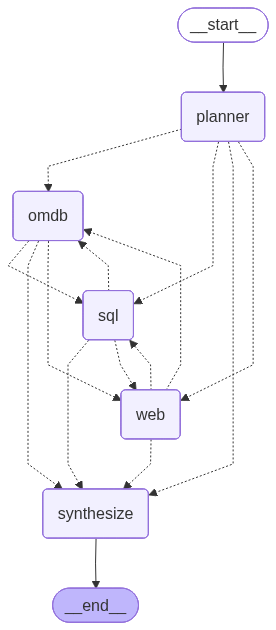

In [6]:
from IPython.display import Image, display

png_graph = app.get_graph().draw_mermaid_png()

display(Image(png_graph))

✅ Image sauvegardée : ../doc/graph_output.png


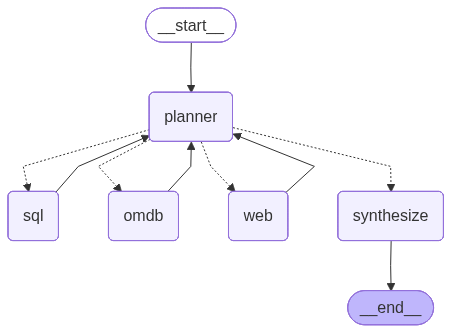

In [3]:
from IPython.display import Image, display
from albert_query_app import app

png_graph = app.get_graph().draw_mermaid_png()

with open("../doc/graph_output.png", "wb") as f:
    f.write(png_graph)
    print("✅ Image sauvegardée : ../doc/graph_output.png")

display(Image(png_graph))

In [11]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
import os
from dotenv import load_dotenv


load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

chat = ChatOpenAI(model="gpt-4o", temperature=0, api_key=OPENAI_API_KEY)

messages = [
    SystemMessage(content="You're a helpful assistant"),
    HumanMessage(content="What are the hot research topics in 2025? Return your answer in 5 sentences and in bullet points."),
]

print(chat.invoke(messages).content)

As of my last update in October 2023, I can't predict the exact research topics that will be hot in 2025, but I can suggest some areas that are likely to continue being significant based on current trends:

- **Artificial Intelligence and Machine Learning**: Continued advancements in AI, particularly in areas like explainable AI, AI ethics, and AI applications in healthcare and autonomous systems, are expected to remain at the forefront of research.

- **Quantum Computing**: As quantum technology progresses, research into practical applications, error correction, and quantum algorithms is likely to be a major focus.

- **Sustainability and Climate Change**: Innovative solutions for renewable energy, carbon capture, and sustainable agriculture will be critical as the world seeks to address climate change and environmental challenges.

- **Biotechnology and Genomics**: Advances in CRISPR and other gene-editing technologies, personalized medicine, and synthetic biology are expected to dri